<a href="https://colab.research.google.com/github/AnkitRajSri/FacialEmotionAI/blob/main/EmotionAI_Facial_Key_Points_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import the dependencies and dataset

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import os
import pandas as pd
import numpy as np
import PIL
import plotly.express as px
import plotly.graph_objects as go
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
%cd /content/drive/MyDrive/Emotion AI

/content/drive/MyDrive/Emotion AI


In [4]:
os.getcwd()

'/content/drive/MyDrive/Emotion AI'

In [5]:
os.listdir()

['Emotion+AI+Slides.pdf',
 'Emotion AI Dataset',
 'best_facialkeypoints_weights.hdf5',
 'facialkeypoints_model.json']

##### Load the facial key points data

In [6]:
facialkey_df = pd.read_csv("Emotion AI Dataset/data.csv")
facialkey_df.shape

In [7]:
facialkey_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


In [8]:
facialkey_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

In [9]:
facialkey_df.isna().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

In [10]:
facialkey_df["Image"].shape

(2140,)

In [11]:
# The values of the image are space separated string values, so we can separate them using " " as separated
# We can then convert them into numpy array using np.fromstring
# Finally, we need to convert the obtained 1D array into 2D array of shape (96, 96)
facialkey_df["Image"] = facialkey_df["Image"].apply(lambda x: np.fromstring(x, dtype=int, sep=" ").reshape(96, 96))

In [12]:
facialkey_df["Image"][0].shape

(96, 96)

In [13]:
facialkey_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,22.361617,38.034571,56.147991,29.222304,79.617523,29.656570,39.272084,29.413747,15.761707,30.452947,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,2.768804,2.654903,2.819914,2.867131,3.312647,3.627187,2.609648,2.842219,3.337901,3.644342,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,11.054589,26.521633,35.581733,15.859361,55.549929,10.522325,25.060327,16.476000,3.826243,13.224453,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,20.631964,36.569765,54.562757,27.590944,77.732395,27.658656,37.555192,27.798773,13.540535,28.268263,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,22.529600,37.876900,56.239984,29.468466,79.797607,29.753523,39.247681,29.528098,15.760876,30.333323,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,24.202338,39.401034,57.926361,31.079433,81.559651,31.763791,40.824154,31.134740,17.871569,32.661300,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,40.050971,50.002113,67.752000,40.293408,94.269957,48.823425,51.300571,39.445859,39.676082,44.857962,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


### Visualize the images

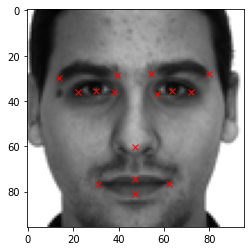

In [14]:
# Select a random image from the dataset along with its key facial features
i = np.random.randint(1, len(facialkey_df))
plt.imshow(facialkey_df["Image"][i], cmap="gray")
for j in range(1, facialkey_df.shape[1], 2):
  plt.plot(facialkey_df.iloc[i, j-1], facialkey_df.iloc[i, j], "rx")

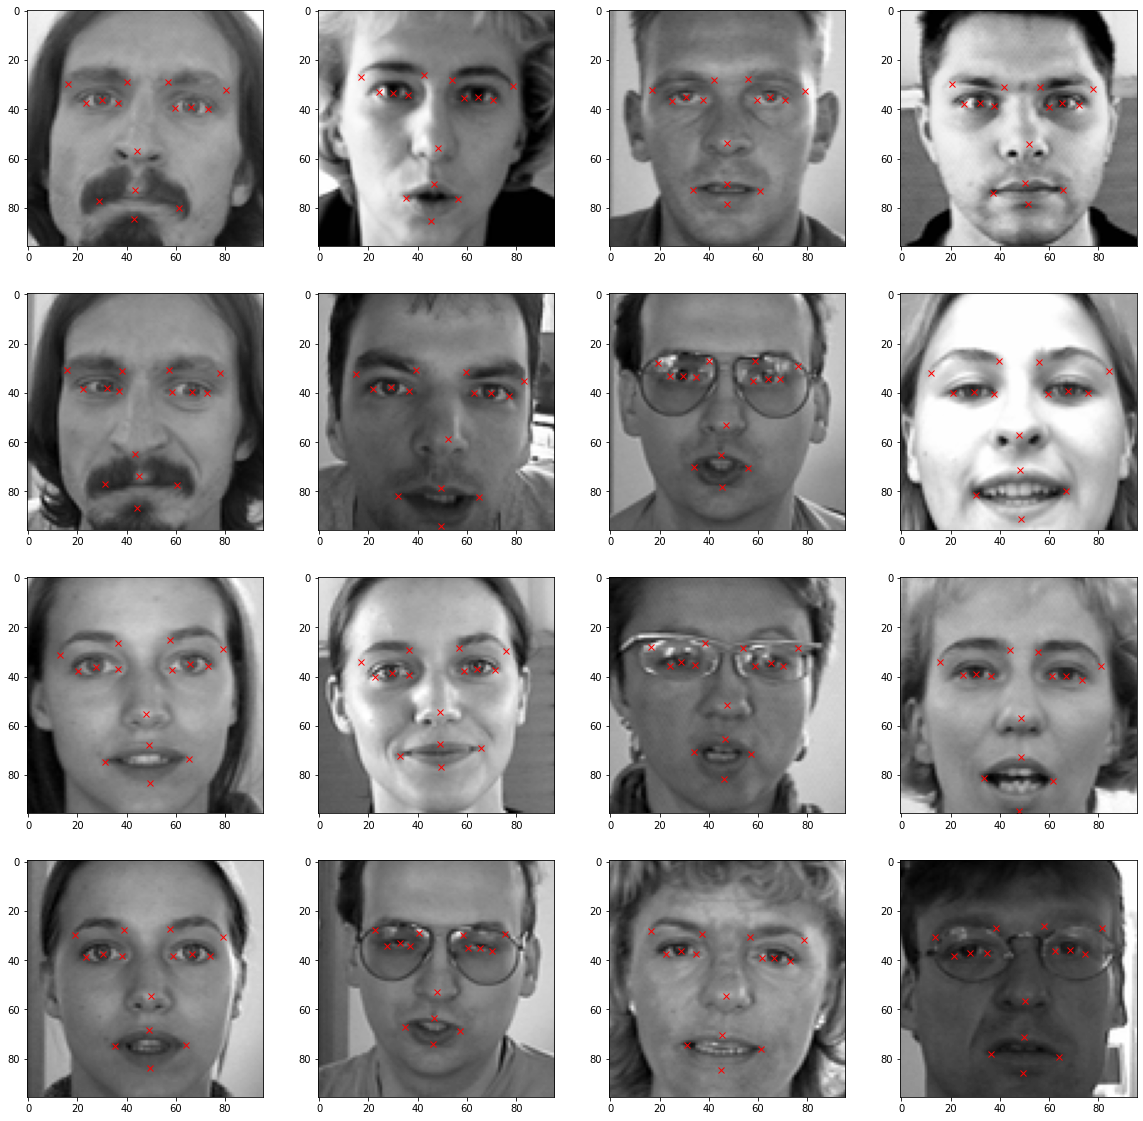

In [15]:
# We can plot more images in a grid format
fig = plt.figure(figsize=(20, 20))

for i in range(16):
  ax = fig.add_subplot(4, 4, i+1)
  image = plt.imshow(facialkey_df["Image"][i], cmap="gray")
  for j in range(1, facialkey_df.shape[1], 2):
    plt.plot(facialkey_df.iloc[i, j-1], facialkey_df.iloc[i, j], "rx")

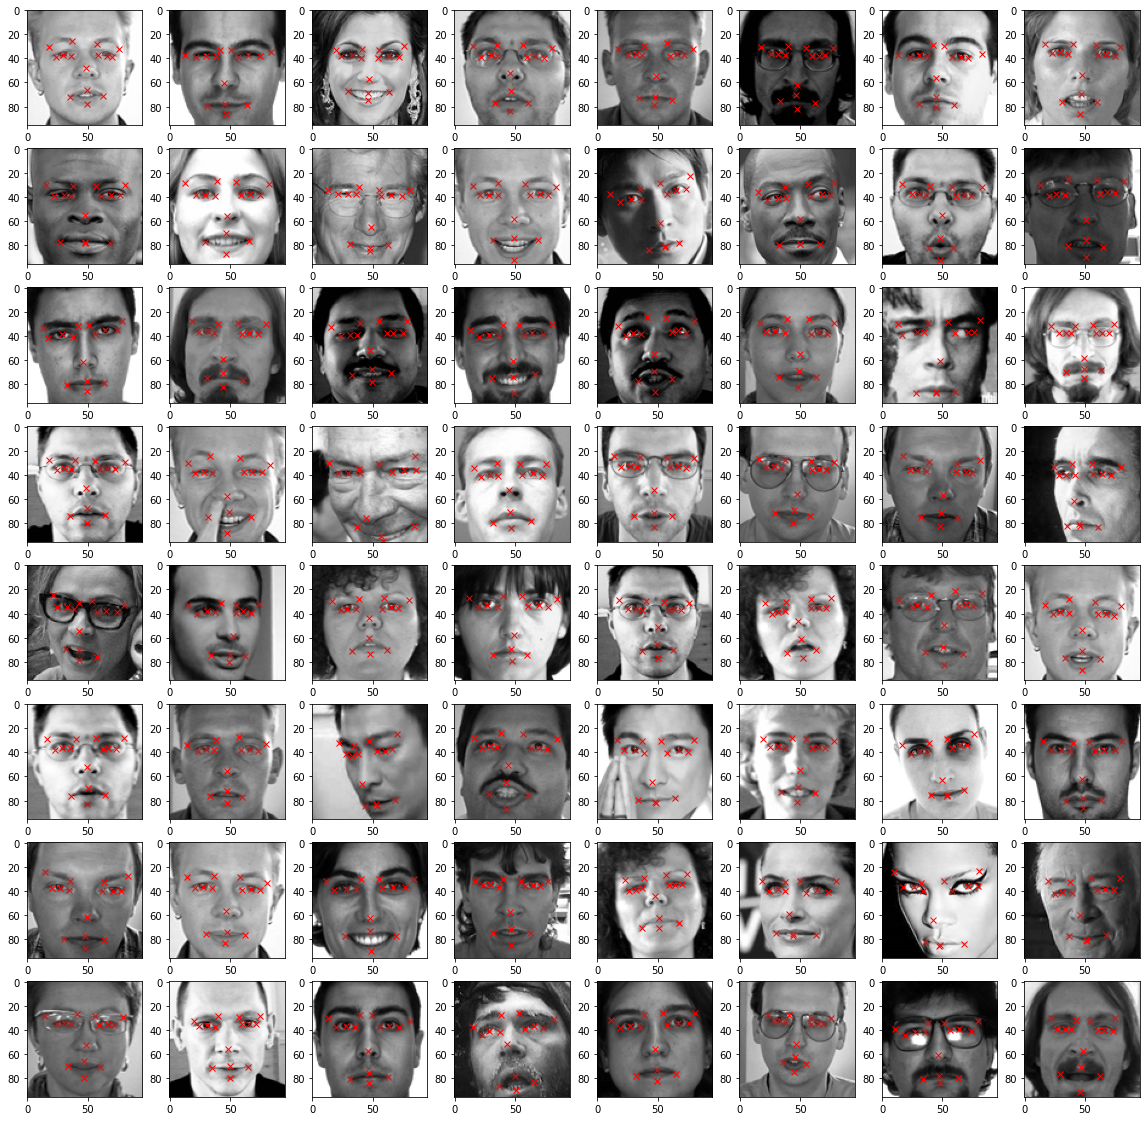

In [16]:
# We can even perform a sanity of 64 random images from the dataset
fig = plt.figure(figsize=(20, 20))

for i in range(64):
  val = np.random.randint(1, len(facialkey_df)-100)
  ax = fig.add_subplot(8, 8, i+1)
  image = plt.imshow(facialkey_df["Image"][val], cmap="gray")
  for j in range(1, facialkey_df.shape[1], 2):
    plt.plot(facialkey_df.iloc[val, j-1], facialkey_df.iloc[val, j], "rx")

### Perform Image Augmentation

In [17]:
facialkey_df_copy = facialkey_df.copy()
facialkey_df_copy.shape

(2140, 31)

In [18]:
columns = facialkey_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

##### Augmentation 1: Horizontal Flipping

In [19]:
# Flip the images along the y-axis
facialkey_df_copy["Image"] = facialkey_df_copy["Image"].apply(lambda x: np.flip(x, axis=1))

# As we are flipping along the y-axis, y-coordinate values would be the same
# Only x-coordinate values would change
# We can achieve that by subtracting our intitial x values from the width of the images
for i in range(len(columns)):
  if i%2 == 0:
    facialkey_df_copy[columns[i]] = facialkey_df_copy[columns[i]].apply(lambda x: 96. - float(x))

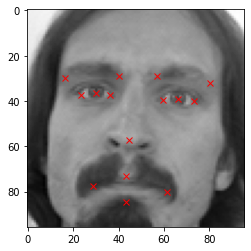

In [20]:
# Show the original image
plt.imshow(facialkey_df["Image"][0], cmap="gray")
for j in range(1, facialkey_df.shape[1], 2):
  plt.plot(facialkey_df.iloc[0, j-1], facialkey_df.iloc[0, j], "rx")

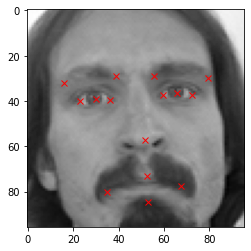

In [21]:
# Show the horizontally flipped image
plt.imshow(facialkey_df_copy["Image"][0], cmap="gray")
for j in range(1, facialkey_df_copy.shape[1], 2):
  plt.plot(facialkey_df_copy.iloc[0, j-1], facialkey_df_copy.iloc[0, j], "rx")

In [22]:
# Concatenate the original dataframe with the augmented dataframe
augmented_df = pd.concat([facialkey_df, facialkey_df_copy], axis=0, ignore_index=True)
augmented_df.shape

(4280, 31)

##### Augmentation 2: Randomly increase the image brightness

In [23]:
# Increase the image brightness by multiplying pixel values by random values between 1.5 to 2
import random

facialkey_df_copy = facialkey_df.copy()
facialkey_df_copy["Image"] = facialkey_df_copy["Image"].apply(lambda x: np.clip(random.uniform(1.5, 2)*x, 0., 255.))

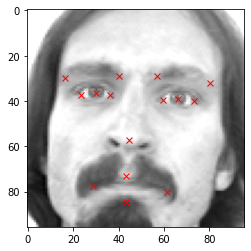

In [24]:
# Show the image with increased brightness
plt.imshow(facialkey_df_copy["Image"][0], cmap="gray")
for j in range(1, facialkey_df_copy.shape[1], 2):
  plt.plot(facialkey_df_copy.iloc[0, j-1], facialkey_df_copy.iloc[0, j], "rx")

In [25]:
augmented_df = pd.concat([augmented_df, facialkey_df_copy], ignore_index=True)
augmented_df.shape

(6420, 31)

##### Augmentation 3: Vertical Flipping

In [26]:
facialkey_df_copy = facialkey_df.copy()

# Flip the images along the x-axis
facialkey_df_copy["Image"] = facialkey_df_copy["Image"].apply(lambda x: np.flip(x, axis=0))

# As we are flipping along the x-axis, x-coordinate values would be the same
# Only y-coordinate values would change
# We can achieve that by subtracting our intitial y values from the width of the images
for i in range(len(columns)):
  if i%2 == 1:
    facialkey_df_copy[columns[i]] = facialkey_df_copy[columns[i]].apply(lambda x: 96. - float(x))

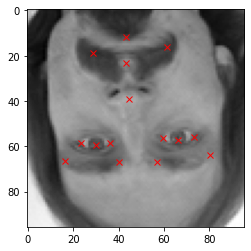

In [27]:
# Show the horizontally flipped image
plt.imshow(facialkey_df_copy["Image"][0], cmap="gray")
for j in range(1, facialkey_df_copy.shape[1], 2):
  plt.plot(facialkey_df_copy.iloc[0, j-1], facialkey_df_copy.iloc[0, j], "rx")

In [28]:
augmented_df = pd.concat([augmented_df, facialkey_df_copy], ignore_index=True)
augmented_df.shape

(8560, 31)

### Data Normalization and Training Data Preparation

In [84]:
# Obtain the image values
img_data = augmented_df.iloc[:, 30]

# Normalize the images
img_data = img_data / 255.

# Create an empty array of shape (x, 96, 96, 1) to feed to the model
X = np.empty((len(img_data), 96, 96, 1))

# Iterate through the image data and add image values to the empty array after expanding their dimensions to (96, 96, 1)
for i in range(len(img_data)):
  X[i,] = np.expand_dims(img_data[i], axis=2)

In [85]:
# Convert the array type to float32
X = np.asarray(X).astype(np.float32)
X.shape

(8560, 96, 96, 1)

In [86]:
# Obtain the values of x & y coordinates to be used as target
y = augmented_df.iloc[:, :30]
y = np.asarray(y).astype(np.float32)
y.shape

(8560, 30)

In [87]:
# Create the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [88]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7704, 96, 96, 1), (856, 96, 96, 1), (7704, 30), (856, 30))

### Deep Residual Neural Network Architecture

##### Build the Residual Neural Network

In [94]:
def res_block(X, filter, stage):

  # Convolutional block
  X_copy = X

  f1, f2, f3 = filter

  # Main path
  X = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"_conv_a", kernel_initializer=glorot_uniform(seed=0))(X)
  X = MaxPool2D((2, 2))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_conv_a")(X)
  X = Activation("relu")(X)

  X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding="same", name="res_"+str(stage)+"_conv_b", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_conv_b")(X)
  X = Activation("relu")(X)

  X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name='res_'+str(stage)+'_conv_c', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis =3, name='bn_'+str(stage)+'_conv_c')(X)

  # Short path
  X_copy = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"conv_copy", kernel_initializer=glorot_uniform(seed=0))(X_copy)
  X_copy = MaxPool2D((2, 2))(X_copy)
  X_copy = BatchNormalization(axis=3, name="bn_"+str(stage)+"_conv_copy")(X_copy)

  # Add both the paths
  X = Add()([X, X_copy])
  X = Activation("relu")(X)

  # Identity block 1
  X_copy = X

  # Main path
  X = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"_identity_1a", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_1a")(X)
  X = Activation("relu")(X)

  X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding="same", name="res_"+str(stage)+"_identity_1b", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_1b")(X)
  X = Activation("relu")(X)

  X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"_identity_1c", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_1c")(X)
  X = Activation("relu")(X)

  # Add both the paths
  X = Add()([X, X_copy])
  X = Activation("relu")(X)

  # Identity block 2
  X_copy = X

  # Main path
  X = Conv2D(f1, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"_identity_2a", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_2a")(X)
  X = Activation("relu")(X)

  X = Conv2D(f2, kernel_size=(3, 3), strides=(1, 1), padding="same", name="res_"+str(stage)+"_identity_2b", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_2b")(X)
  X = Activation("relu")(X)

  X = Conv2D(f3, kernel_size=(1, 1), strides=(1, 1), name="res_"+str(stage)+"_identity_2c", kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis=3, name="bn_"+str(stage)+"_identity_2c")(X)
  X = Activation("relu")(X)

  # Add both the paths
  X = Add()([X, X_copy])
  X = Activation("relu")(X)

  return X

In [ ]:
input_shape = (96, 96, 1)

# Input tensor
X_input = Input(input_shape)

# Zero padding layer
X = ZeroPadding2D((3, 3))(X_input)

# Stage 1
X = Conv2D(64, kernel_size=(7, 7), strides=(2, 2), name="conv_1", kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis=3, name="bn_conv_1")(X)
X = Activation("relu")(X)
X = MaxPooling2D((3, 3), strides=(2, 2))(X)

# Stage 2
X = res_block(X, filter=[64, 64, 256], stage=2)

# Stage 3
X = res_block(X, filter=[128, 128, 512], stage=3)

# Stage 4
X = res_block(X, filter=[256, 256, 1024], stage=4)

# Stage 5
# Average Pooling layer
X = AveragePooling2D((2, 2), name="Average_Pooling")(X)

# Stage 5
# Final layer
X = Flatten()(X)
X = Dense(4096, activation="relu")(X)
X = Dropout(0.2)(X)
X = Dense(2048, activation="relu")(X)
X = Dropout(0.1)(X)
X = Dense(30, activation="relu")(X)

# Build the model
facialkeypoints_model = Model(inputs=X_input, outputs=X)
facialkeypoints_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 102, 102, 1)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 48, 48, 64)   3200        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
bn_conv_1 (BatchNormalization)  (None, 48, 48, 64)   256         conv_1[0][0]                     
___________________________________________________________________________________________

##### Compile and train the ResNet

In [96]:
adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
facialkeypoints_model.compile(optimizer=adam, loss="mean_squared_error", metrics=["accuracy"])

In [97]:
checkpointer = ModelCheckpoint(filepath = "best_facialkeypoints_weights.hdf5", monitor="val_accuracy", verbose = 1, save_best_only = True)

In [98]:
history = facialkeypoints_model.fit(X_train, y_train, batch_size = 32, epochs = 20, validation_split = 0.1, callbacks=[checkpointer])

Epoch 1/20
217/217 [==============================] - 9s 28ms/step - loss: 661.3274 - accuracy: 0.3101 - val_loss: 694.1189 - val_accuracy: 0.3671

Epoch 00001: val_accuracy improved from -inf to 0.36706, saving model to best_facialkeypoints_weights.hdf5
Epoch 2/20
217/217 [==============================] - 6s 25ms/step - loss: 93.7316 - accuracy: 0.6998 - val_loss: 192.1238 - val_accuracy: 0.6576

Epoch 00002: val_accuracy improved from 0.36706 to 0.65759, saving model to best_facialkeypoints_weights.hdf5
Epoch 3/20
217/217 [==============================] - 5s 25ms/step - loss: 61.0425 - accuracy: 0.6801 - val_loss: 84.1770 - val_accuracy: 0.7523

Epoch 00003: val_accuracy improved from 0.65759 to 0.75227, saving model to best_facialkeypoints_weights.hdf5
Epoch 4/20
217/217 [==============================] - 5s 25ms/step - loss: 48.2812 - accuracy: 0.6771 - val_loss: 76.6202 - val_accuracy: 0.7562

Epoch 00004: val_accuracy improved from 0.75227 to 0.75616, saving model to best_facia

In [99]:
# Save the model architecture as a json file
model_json = facialkeypoints_model.to_json()
with open("facialkeypoints_model.json", "w") as json_file:
  json_file.write(model_json)

In [100]:
# Evaluate the default model
result = facialkeypoints_model.evaluate(X_test, y_test)
print("Accuracy : {}".format(result[1]))

27/27 [==============================] - 0s 14ms/step - loss: 59.0424 - accuracy: 0.7582
Accuracy : 0.7581775784492493


In [101]:
with open("Emotion AI Dataset/detection.json", "r") as json_file:
    json_saved_model= json_file.read()
best_model = models.model_from_json(json_saved_model)
best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 102, 102, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   3200        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 48, 48, 64)   256         conv1[0][0]                      
______________________________________________________________________________________________